Camembert pour les descriptions

- On entraine QUE sur les lignes qui ont des desc
- On sauve le modele
- On Evalue le modele
- On recharge le modele, génère les embeddings et les sauve dans un CSV

In [1]:
from RktnChallenge.RktnModel import ModelTrainer



import tensorflow as tf


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import CamembertTokenizer, TFCamembertForSequenceClassification
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import AdamW

import ast

trainer = ModelTrainer("data_tr_lemm.csv","")
nb_epochs = 10
num_categories = 27
max_features = 250
checkpoint_path = "cbert_best_desc"

#malheureusement les arrays sont convertis
#en chaine de caractères, on doit re-caster
def convert_and_join(str_list):
    try:        
        real_list = ast.literal_eval(str_list)        
        return " ".join(real_list)
    except (ValueError, SyntaxError):
        return ""



labels = y = trainer.encodeLabel("prdtypecode")
sentences =  trainer.data["description_tkn"].apply(convert_and_join).values.tolist()

sentences_train, sentences_test, labels_train, labels_test = train_test_split(sentences, labels, test_size=0.2, random_state=42)

valid_indices = [i for i, x in enumerate(sentences_train) if x != ""]



sentences_train = [sentences_train[i] for i in valid_indices]
labels_train = [labels_train[i] for i in valid_indices]



from transformers import CamembertConfig, TFCamembertModel
modelpoint = 'jplu/tf-camembert-base'
config = CamembertConfig.from_pretrained(modelpoint)
config.num_labels = 27
tokenizer = CamembertTokenizer.from_pretrained(modelpoint)
model = TFCamembertForSequenceClassification.from_pretrained(modelpoint, config=config)



def encode_sentences(sentences, tokenizer, max_length=max_features):
    encodings = tokenizer(sentences, padding='max_length', truncation=True, max_length=max_length, return_tensors='tf')
    return {"input_ids": encodings["input_ids"], "attention_mask": encodings["attention_mask"]}
    

print("encoding sentences...")
X_train = encode_sentences(sentences_train, tokenizer)
X_test = encode_sentences(sentences_test, tokenizer)

y_train = np.array(labels_train)
y_test = np.array(labels_test)

from transformers import AdamWeightDecay

print("compile model...")
#optimizer = AdamW(weight_decay=0.01, learning_rate=0.001) 
optimizer = Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
loss = SparseCategoricalCrossentropy(from_logits=True)

for layer in model.layers:
    layer.trainable = False
num_layers = len(model.layers)
for i in range(num_layers - 2, num_layers): 
    model.layers[i].trainable = True
    
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


early_stopper = tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy', mode='auto', patience=2, 
            verbose=1, restore_best_weights=True
        )        

print("fit...")
history = model.fit(X_train, y_train, validation_split=0.2, epochs=nb_epochs, batch_size=8, callbacks=[early_stopper])
model.save_pretrained(checkpoint_path)
tokenizer.save_pretrained(checkpoint_path)


2023-09-11 22:30:45.393127: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-11 22:30:45.994901: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9511] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-09-11 22:30:45.994924: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-09-11 22:30:46.005467: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-11 22:30:46.310798: I tensorflow/core/platform/cpu_feature_guar

encoding sentences...
compile model...
fit...
Epoch 1/10


2023-09-11 22:31:28.201994: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
external_state_policy: POLICY_IGNORE
autotune_options {
}
warm_start: false

2023-09-11 22:31:46.892639: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f8e0c234f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-11 22:31:46.892675: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA TITAN X (Pascal), Compute Capability 6.1
2023-09-11 22:31:46.910560: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-11 22:31:47.189102: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-09-11 22:31:47.261165: I ./tensor

4402/4402 [==============================] - ETA: 0s - loss: 1.2229 - accuracy: 0.6863

2023-09-11 23:26:43.794379: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



4402/4402 [==============================] - 3454s 779ms/step - loss: 1.2229 - accuracy: 0.6863 - val_loss: 0.7264 - val_accuracy: 0.7944
Epoch 2/10
4402/4402 [==============================] - 5938s 1s/step - loss: 0.6088 - accuracy: 0.8229 - val_loss: 0.6126 - val_accuracy: 0.8214
Epoch 3/10
4402/4402 [==============================] - 5857s 1s/step - loss: 0.4630 - accuracy: 0.8594 - val_loss: 0.5920 - val_accuracy: 0.8302
Epoch 4/10
4402/4402 [==============================] - 5835s 1s/step - loss: 0.3679 - accuracy: 0.8857 - val_loss: 0.5885 - val_accuracy: 0.8375
Epoch 5/10
4402/4402 [==============================] - 5844s 1s/step - loss: 0.3026 - accuracy: 0.9037 - val_loss: 0.5924 - val_accuracy: 0.8418
Epoch 6/10
4402/4402 [==============================] - 5913s 1s/step - loss: 0.2454 - accuracy: 0.9217 - val_loss: 0.6438 - val_accuracy: 0.8360
Epoch 7/10
4402/4402 [==============================] - 5746s 1s/step - loss: 0.2041 - accuracy: 0.9327 - val_loss: 0.7037 - val_acc

('cbert_best_desc/tokenizer_config.json',
 'cbert_best_desc/special_tokens_map.json',
 'cbert_best_desc/sentencepiece.bpe.model',
 'cbert_best_desc/added_tokens.json')

In [6]:
model.save_pretrained(checkpoint_path)
tokenizer.save_pretrained(checkpoint_path)


All PyTorch model weights were used when initializing TFCamembertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFCamembertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2023-09-11 11:21:39.488333: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ./cbert_best_desi: FAILED_PRECONDITION: cbert_best_desi; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [ ]:

model = TFCamembertForSequenceClassification.from_pretrained(checkpoint_path)
tokenizer = CamembertTokenizer.from_pretrained(checkpoint_path)

In [3]:

y_pred_test = model.predict(X_test)


2023-09-12 09:14:59.572403: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



531/531 [==============================] - 240s 447ms/step


weighted F1 score: 0.5991955200509936


/home/pec/Rktn/RktnChallenge/RktnModel.py:191: RuntimeWarning: invalid value encountered in divide
  normalized_conf_matrix = conf_matrix / row_sums[ np.newaxis,:]*100


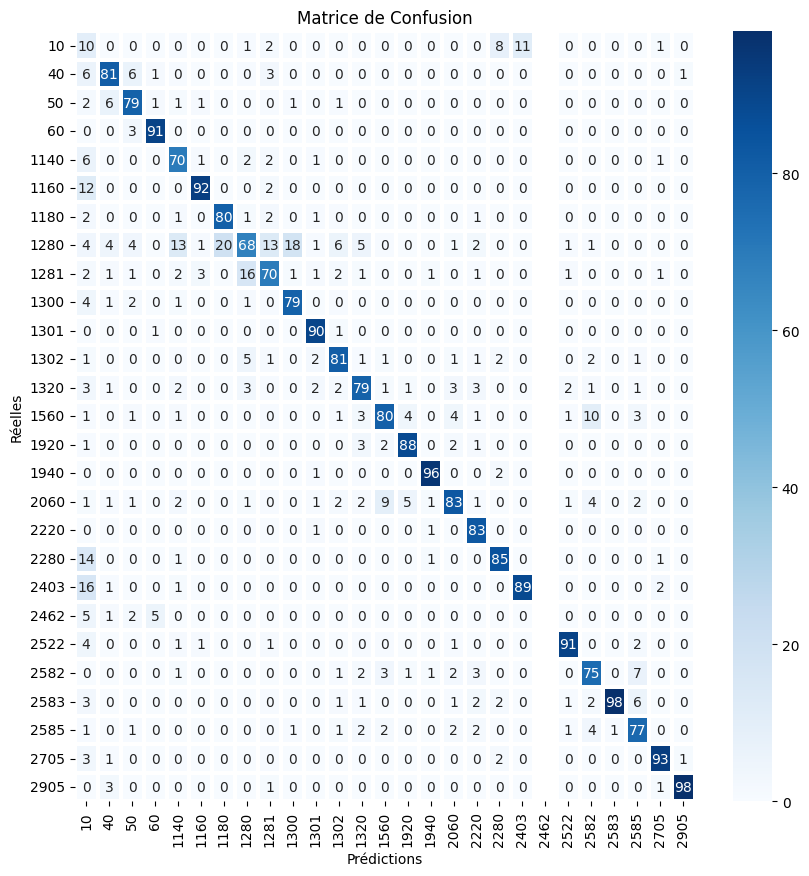

In [4]:

y_pred_out = y_pred_test.logits
y_pred = np.argmax(y_pred_out, axis=-1)

trainer.evaluateTestResults(y_test,y_pred)

In [1]:
from RktnChallenge.RktnModel import ModelTrainer



import tensorflow as tf


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import CamembertTokenizer, TFCamembertForSequenceClassification
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import AdamW

import ast

trainer = ModelTrainer("data_tr_lemm.csv","")
nb_epochs = 10
num_categories = 27
max_features = 250
checkpoint_path = "cbert_best_desc"


def convert_and_join(str_list):
    try:        
        real_list = ast.literal_eval(str_list)
        return " ".join(real_list)
    except (ValueError, SyntaxError):
        return ""



sentences =  trainer.data["description_tkn"].apply(convert_and_join).values.tolist()

from transformers import CamembertConfig, TFCamembertModel

config = CamembertConfig.from_pretrained(checkpoint_path)
config.num_labels = 27
tokenizer = CamembertTokenizer.from_pretrained(checkpoint_path)
model = TFCamembertModel.from_pretrained(checkpoint_path, config=config)


for layer in model.layers:
    layer.trainable = False




2023-09-12 17:55:22.246881: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-12 17:55:22.272797: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9511] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-09-12 17:55:22.272824: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-09-12 17:55:22.272838: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-12 17:55:22.279405: I tensorflow/core/platform/cpu_feature_guar

In [2]:
from tqdm import tqdm

def sentence_to_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors="tf", truncation=True,  max_length=max_features)
    outputs = model(inputs.input_ids)
    embeddings = outputs.last_hidden_state
    
    embeddings = tf.reduce_mean(embeddings, axis=1)    
    return embeddings.numpy()

df = pd.read_csv("embeddings.csv")

# embeddings pour chaque texte
df['embeddings_desc'] = [sentence_to_embedding(text) for text in tqdm(sentences)]

df.to_csv("embeddings_final.csv", index=False)


100%|██████████| 84916/84916 [2:30:34<00:00,  9.40it/s]  


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import CamembertTokenizer, TFCamembertModel
from tqdm import tqdm


del df

tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
model = TFCamembertModel.from_pretrained("camembert-base")


def sentence_to_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors="tf", truncation=True, padding=True, max_length=256)
    outputs = model(inputs.input_ids)
    embeddings = outputs.last_hidden_state
    
    embeddings = tf.reduce_mean(embeddings, axis=1)    
    return embeddings.numpy()

# Créez un DataFrame exemple
df = pd.read_csv("data_tr_lemm.csv")

# Générez les embeddings pour chaque texte
df['embeddings'] = [sentence_to_embedding(text) for text in tqdm(df['description_tkn'])]

df.to_csv("embeddings_desc_256.csv", index=False)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFCamembertModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFCamembertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFCamembertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFCamembertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.
100%|██████████| 84916/84916 [2:47:15<00:00,  8.46it/s]  


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import CamembertTokenizer, TFCamembertModel
from tqdm import tqdm


del df

tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
model = TFCamembertModel.from_pretrained("camembert-base")


def sentence_to_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors="tf", truncation=True, padding=True, max_length=256)
    outputs = model(inputs.input_ids)
    embeddings = outputs.last_hidden_state
    
    embeddings = tf.reduce_mean(embeddings, axis=1)    
    return embeddings.numpy()


df = pd.read_csv("data_tr_lemm.csv")

df['embeddings'] = [sentence_to_embedding(text) for text in tqdm(df['designation_tkn'])]

df.to_csv("embeddings_desi_256.csv", index=False)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFCamembertModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFCamembertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFCamembertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFCamembertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.
100%|██████████| 84916/84916 [2:46:44<00:00,  8.49it/s]  
